# Machine Learning Model for Automated Identification of Cell Types and Annotation of Clusters
### Datasets: MacParland Human Data and Wang Mouse Data

In [1]:
!pip install anndata
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=89f7d350d4c6e1f08168f033dae31dd1239e14b6388f8d5ffc0456b2ccd00751
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [23]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2

##### Import Libraries

In [5]:
import sys
import joblib
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import scipy
import statistics
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from random import randint
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import safetensors

In [6]:
print("joblib version:", joblib.__version__)
print("torch version:", torch.__version__)
print("sklearn version:", sklearn.__version__)
print("scipy version:", scipy.__version__)

joblib version: 1.4.2
torch version: 2.1.2+cpu
sklearn version: 1.2.2
scipy version: 1.11.4


## Model Creation

### Random Forest

#### Human

##### Prepare Data

In [7]:
human_exp_data_path = "/kaggle/input/human-data/GSE115469_Data.csv"
human_cluster_data_path = "/kaggle/input/human-data/GSE115469_CellClusterType.txt"

human_exp_data = pd.read_csv(human_exp_data_path)

human_exp_data = human_exp_data.set_index("Unnamed: 0").T
human_exp_data.index.name = "CellName"

human_clusters_data = pd.read_csv(human_cluster_data_path, sep = "\t")

human_clusters_data = human_clusters_data[["CellName", "CellType"]]

Merge Datasets

In [8]:
human_data = pd.merge(human_exp_data, human_clusters_data, on='CellName', how='inner')
del(human_exp_data)
del(human_clusters_data)

In [9]:
human_cols = human_data.columns
human_gene_cols = human_cols.drop(["CellName", "CellType"])
human_gene_cols = human_gene_cols.tolist()

print(human_data)

                      CellName  RP11-34P13.7  FO538757.2  AP006222.2  \
0     P1TLH_AAACCTGAGCAGCCTC_1           0.0         0.0    0.000000   
1     P1TLH_AAACCTGTCCTCATTA_1           0.0         0.0    0.314760   
2     P1TLH_AAACCTGTCTAAGCCA_1           0.0         0.0    0.000000   
3     P1TLH_AAACGGGAGTAGGCCA_1           0.0         0.0    0.000000   
4     P1TLH_AAACGGGGTTCGGGCT_1           0.0         0.0    0.000000   
...                        ...           ...         ...         ...   
8439  P5TLH_TTTGTCAGTGTTCTTT_1           0.0         0.0    0.000000   
8440  P5TLH_TTTGTCAGTTTAGGAA_1           0.0         0.0    1.140429   
8441  P5TLH_TTTGTCATCAGCTTAG_1           0.0         0.0    0.000000   
8442  P5TLH_TTTGTCATCCACGCAG_1           0.0         0.0    0.000000   
8443  P5TLH_TTTGTCATCGGCATCG_1           0.0         0.0    0.000000   

      RP4-669L17.10  RP5-857K21.4  RP11-206L10.9  LINC00115  FAM41C  \
0               0.0           0.0            0.0        0.0     

##### Train Model

In [10]:
hX = human_data[human_gene_cols]
hy = human_data['CellType']


hle = LabelEncoder()
hy = hle.fit_transform(hy)

In [11]:
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=0.2, random_state=42)

In [12]:
del(human_data)
del hX
del hy

In [32]:
human_model = RandomForestClassifier(max_depth = 20, max_features = "sqrt", min_samples_leaf = 1, min_samples_split = 10, n_estimators = 170, class_weight = "balanced")
human_model.fit(hX_train, hy_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10, n_estimators=170)

Evaluate Model on Test Data

In [33]:
hy_pred = human_model.predict(hX_test)

# Calculate accuracy
human_accuracy = accuracy_score(hy_test, hy_pred)
print(f"Accuracy: {human_accuracy:.2f}")

# Print detailed classification report
print("\nClassification Report:")
human_report = (classification_report(hy_test, hy_pred, target_names=hle.classes_))

# human_report = human_report.split("\n")


# for i in range(len(human_report)):
#     out = human_report[i].strip()
#     out = out.split("       ")
#     human_report[i] = out

# human_report.remove([""])

# human_report = pd.DataFrame(human_report)

print(human_report)
#human_report.to_csv("human_model_report.csv")

Accuracy: 0.93

Classification Report:
                             precision    recall  f1-score   support

       Central_venous_LSECs       0.94      0.97      0.95        76
             Cholangiocytes       1.00      1.00      1.00        24
            Erythroid_Cells       1.00      1.00      1.00        22
     Hepatic_Stellate_Cells       1.00      1.00      1.00         8
               Hepatocyte_1       0.84      0.92      0.88       192
               Hepatocyte_2       0.91      0.86      0.88       167
               Hepatocyte_3       0.91      1.00      0.96       128
               Hepatocyte_4       0.88      0.84      0.86       130
               Hepatocyte_5       1.00      0.80      0.89        49
               Hepatocyte_6       0.88      0.83      0.86        36
    Inflammatory_Macrophage       0.95      0.97      0.96       147
             Mature_B_Cells       0.96      1.00      0.98        25
              NK-like_Cells       0.97      0.95      0.96     

#### Mouse

##### Prepare Data

In [54]:
mouse_ad = ad.read_h5ad("/kaggle/input/mousedata/mouse_liver_data.h5ad")

mouse_exp_cluster_num_to_celltype = ["Hep1", "Hep2", "Endo1", "Macrophages", "HSC1", "Hep3", "T_cell", "Hep4", "Cholangio", "Endo2", "Hep5", "HSC2", "Endo3", "Dividing", "DC", "B_cell", "Mesothelial", "Unknown_immune"]

mouse_exp_data = pd.DataFrame(mouse_ad.X, index = mouse_ad.obs.index, columns = mouse_ad.var.index)
#mouse_exp_data = mouse_exp_data.set_index("Unnamed: 0").T

mouse_clusters_data = pd.DataFrame(mouse_ad.obs["seurat_clusters"])
mouse_clusters_data.index.name = "CellName"
mouse_clusters_data.columns = ["CellType"]
mouse_clusters_data["CellType"] = mouse_clusters_data["CellType"].apply(lambda x: mouse_exp_cluster_num_to_celltype[x])
mouse_exp_data.index.name = "CellName"

Merge Datasets

In [55]:
mouse_data = pd.merge(mouse_exp_data, mouse_clusters_data, on='CellName', how='inner')

In [56]:
mouse_cols = mouse_data.columns
mouse_gene_cols = mouse_cols.drop(["CellType"])
mouse_gene_cols = mouse_gene_cols.tolist()

print(mouse_data)

                              Xkr4    Gm1992   Gm37381       Rp1     Sox17  \
CellName                                                                     
Norm1_AAACCCAAGATAGTCA-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm1_AAACCCACATTGAAGA-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm1_AAACCCAGTGGTTTGT-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm1_AAAGTGAAGTCGTCTA-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm1_AACAAAGGTTCAAACC-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
...                            ...       ...       ...       ...       ...   
Norm2_TTTGTTGCATGAATAG-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm2_TTTGTTGGTATCGAGG-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm2_TTTGTTGGTGGCTGAA-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm2_TTTGTTGGTTCCATTT-1 -0.142654 -0.030922 -0.019887 -0.066082 -0.138328   
Norm2_TTTGTTGTCTTCGACC-1 -0.142654 -0.030922 -0.019887 -0.066082

##### Train Model

In [57]:
mX = mouse_data[mouse_gene_cols]
my = mouse_data['CellType']
print(np.unique(my))

mle = LabelEncoder()
my = mle.fit_transform(my)

#smote = SMOTE(sampling_strategy='not majority')

['B_cell' 'Cholangio' 'DC' 'Dividing' 'Endo1' 'Endo2' 'Endo3' 'HSC1'
 'HSC2' 'Hep1' 'Hep2' 'Hep3' 'Hep4' 'Hep5' 'Macrophages' 'Mesothelial'
 'T_cell' 'Unknown_immune']


Generate Testing/Training Datasets

In [58]:
mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.2, random_state=72)

Generate Balancing Weights

Initialize model, Optimize Hyperparams

In [59]:
mouse_model = RandomForestClassifier(max_depth = 20, max_features = "sqrt", min_samples_leaf = 4, min_samples_split = 6, n_estimators = 199, class_weight = "balanced")
#mouse_model = RandomForestClassifier(max_depth = 30, max_features = "sqrt", min_samples_leaf = 1, min_samples_split = 4, n_estimators = 101, class_weight = "balanced")

#weighted_train = Pipeline(steps=[("sampling", smote), ("classifier", mouse_model)])\

# mouse_param_dist = {
#     'n_estimators': scipy.stats.randint(100, 201),  # This will sample integers from 100 to 200
#     'max_depth': [None] + list(range(10, 31, 10)),  # [None, 10, 20, 30]
#     'min_samples_split': scipy.stats.randint(2, 11),
#     'min_samples_leaf': scipy.stats.randint(1, 5),
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# mouse_random_search = RandomizedSearchCV(
#     estimator=mouse_model,
#     param_distributions=mouse_param_dist,
#     n_iter=50,  # Number of parameter settings that are sampled
#     cv=3,  # 3-fold cross-validation
#     scoring='f1_weighted',  # Use an appropriate scoring metric
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

#these take a lot of time so I ran them in another file and recorded the optimal hyperparameters, with which I am initializing the classifier

Clear all unnecessary variables to free up RAM

Train Model

In [60]:
#mouse_random_search.fit(mX_train, my_train, sample_weight=mouse_cells_bal_weights)

mouse_model.fit(mX_train, my_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=199)

Initial Evaluation

In [61]:
my_pred = mouse_model.predict(mX_test)

unique_classes = np.unique(np.concatenate((my_test, my_pred)))
print(unique_classes)
print("Unique classes in test data:", np.unique(my_test))
print("Unique classes in predictions:", np.unique(my_pred))
print(mle.classes_)
maccuracy = accuracy_score(my_test, my_pred)
print(f"Accuracy: {maccuracy:.2f}")

print("\nClassification Report: ")
print(classification_report(my_test, my_pred, target_names=mle.classes_))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique classes in test data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique classes in predictions: [ 0  1  3  4  5  6  7  9 10 11 12 14 15 16 17]
['B_cell' 'Cholangio' 'DC' 'Dividing' 'Endo1' 'Endo2' 'Endo3' 'HSC1'
 'HSC2' 'Hep1' 'Hep2' 'Hep3' 'Hep4' 'Hep5' 'Macrophages' 'Mesothelial'
 'T_cell' 'Unknown_immune']
Accuracy: 0.85

Classification Report: 
                precision    recall  f1-score   support

        B_cell       0.77      0.71      0.74        14
     Cholangio       0.67      0.80      0.73         5
            DC       0.00      0.00      0.00        19
      Dividing       1.00      0.32      0.48        19
         Endo1       0.84      0.98      0.91       272
         Endo2       0.85      0.77      0.81        79
         Endo3       1.00      0.23      0.38        26
          HSC1       0.98      0.95      0.96       219
          HSC2       0.00      0.00      0.00         5
          He

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network

#### Human

In [13]:


# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
h_hidden_size = 256
h_batch_size = 128
h_num_epochs = 10

# Prepare data loaders
nhX_train = torch.FloatTensor(hX_train.values)
nhX_test = torch.FloatTensor(hX_test.values)
nhy_train = torch.LongTensor(hy_train)
nhy_test = torch.LongTensor(hy_test)

nh_train_dataset = TensorDataset(nhX_train, nhy_train)
nh_test_dataset = TensorDataset(nhX_test, nhy_test)
nh_train_loader = DataLoader(dataset=nh_train_dataset, batch_size=h_batch_size, shuffle=True)
nh_test_loader = DataLoader(dataset=nh_test_dataset, batch_size=h_batch_size, shuffle=False)

# Initialize the model
human_model_nn = Net(nhX_train.shape[1], h_hidden_size, len(hle.classes_))
if torch.cuda.device_count() > 1:
    human_model_nn = nn.DataParallel(human_model_nn)
human_model_nn.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(human_model_nn.parameters(), lr=0.001)

# Training loop
for epoch in range(h_num_epochs):
    human_model_nn.train()
    total_loss = 0
    for inputs, labels in tqdm(nh_train_loader, desc=f"Epoch {epoch+1}/{h_num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = human_model_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{h_num_epochs}], Loss: {total_loss/len(nh_train_loader):.4f}")

# Evaluation
human_model_nn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in nh_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = human_model_nn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=hle.classes_, zero_division = 0))

Using device: cpu


Epoch 1/10: 100%|██████████| 53/53 [00:05<00:00,  9.11it/s]


Epoch [1/10], Loss: 0.5224


Epoch 2/10: 100%|██████████| 53/53 [00:05<00:00,  9.44it/s]


Epoch [2/10], Loss: 0.0355


Epoch 3/10: 100%|██████████| 53/53 [00:05<00:00, 10.08it/s]


Epoch [3/10], Loss: 0.0115


Epoch 4/10: 100%|██████████| 53/53 [00:05<00:00, 10.26it/s]


Epoch [4/10], Loss: 0.0057


Epoch 5/10: 100%|██████████| 53/53 [00:05<00:00, 10.05it/s]


Epoch [5/10], Loss: 0.0035


Epoch 6/10: 100%|██████████| 53/53 [00:05<00:00,  9.70it/s]


Epoch [6/10], Loss: 0.0023


Epoch 7/10: 100%|██████████| 53/53 [00:05<00:00,  9.32it/s]


Epoch [7/10], Loss: 0.0016


Epoch 8/10: 100%|██████████| 53/53 [00:05<00:00,  9.43it/s]


Epoch [8/10], Loss: 0.0011


Epoch 9/10: 100%|██████████| 53/53 [00:05<00:00, 10.07it/s]


Epoch [9/10], Loss: 0.0009


Epoch 10/10: 100%|██████████| 53/53 [00:05<00:00, 10.07it/s]


Epoch [10/10], Loss: 0.0006

Classification Report:
                             precision    recall  f1-score   support

       Central_venous_LSECs       0.97      0.97      0.97        76
             Cholangiocytes       1.00      1.00      1.00        24
            Erythroid_Cells       1.00      1.00      1.00        22
     Hepatic_Stellate_Cells       1.00      1.00      1.00         8
               Hepatocyte_1       0.90      0.92      0.91       192
               Hepatocyte_2       0.90      0.95      0.92       167
               Hepatocyte_3       0.98      1.00      0.99       128
               Hepatocyte_4       0.93      0.89      0.91       130
               Hepatocyte_5       1.00      0.96      0.98        49
               Hepatocyte_6       0.94      0.81      0.87        36
    Inflammatory_Macrophage       0.97      0.98      0.97       147
             Mature_B_Cells       0.96      1.00      0.98        25
              NK-like_Cells       0.99      0.99  

In [17]:
print(hX_train, hX_test)

      RP11-34P13.7  FO538757.2  AP006222.2  RP4-669L17.10  RP5-857K21.4  \
1507           0.0         0.0         0.0            0.0           0.0   
2802           0.0         0.0         0.0            0.0           0.0   
3518           0.0         0.0         0.0            0.0           0.0   
4076           0.0         0.0         0.0            0.0           0.0   
842            0.0         0.0         0.0            0.0           0.0   
...            ...         ...         ...            ...           ...   
5734           0.0         0.0         0.0            0.0           0.0   
5191           0.0         0.0         0.0            0.0           0.0   
5390           0.0         0.0         0.0            0.0           0.0   
860            0.0         0.0         0.0            0.0           0.0   
7270           0.0         0.0         0.0            0.0           0.0   

      RP11-206L10.9  LINC00115  FAM41C  RP11-54O7.1  RP11-54O7.3  ...  \
1507            0.0       

#### Mouse

In [62]:


# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
m_hidden_size = 256
m_batch_size = 128
m_num_epochs = 10

# Prepare data loaders
nmX_train = torch.FloatTensor(mX_train.values)
nmX_test = torch.FloatTensor(mX_test.values)
nmy_train = torch.LongTensor(my_train)
nmy_test = torch.LongTensor(my_test)

nm_train_dataset = TensorDataset(nmX_train, nmy_train)
nm_test_dataset = TensorDataset(nmX_test, nmy_test)
nm_train_loader = DataLoader(dataset=nm_train_dataset, batch_size=m_batch_size, shuffle=True)
nm_test_loader = DataLoader(dataset=nm_test_dataset, batch_size=m_batch_size, shuffle=False)

# Initialize the model
mouse_model_nn = Net(nmX_train.shape[1], m_hidden_size, len(mle.classes_))
if torch.cuda.device_count() > 1:
    mouse_model_nn = nn.DataParallel(mouse_model_nn)
mouse_model_nn.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mouse_model_nn.parameters(), lr=0.001)

# Training loop
for epoch in range(m_num_epochs):
    mouse_model_nn.train()
    total_loss = 0
    for inputs, labels in tqdm(nm_train_loader, desc=f"Epoch {epoch+1}/{m_num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mouse_model_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{m_num_epochs}], Loss: {total_loss/len(nm_train_loader):.4f}")

# Evaluation
mouse_model_nn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in nm_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mouse_model_nn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=mle.classes_, zero_division = 0))

Using device: cpu


Epoch 1/10: 100%|██████████| 82/82 [00:20<00:00,  4.00it/s]


Epoch [1/10], Loss: 0.5948


Epoch 2/10: 100%|██████████| 82/82 [00:20<00:00,  4.05it/s]


Epoch [2/10], Loss: 0.0156


Epoch 3/10: 100%|██████████| 82/82 [00:21<00:00,  3.83it/s]


Epoch [3/10], Loss: 0.0017


Epoch 4/10: 100%|██████████| 82/82 [00:21<00:00,  3.79it/s]


Epoch [4/10], Loss: 0.0009


Epoch 5/10: 100%|██████████| 82/82 [00:21<00:00,  3.79it/s]


Epoch [5/10], Loss: 0.0006


Epoch 6/10: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s]


Epoch [6/10], Loss: 0.0004


Epoch 7/10: 100%|██████████| 82/82 [00:19<00:00,  4.12it/s]


Epoch [7/10], Loss: 0.0003


Epoch 8/10: 100%|██████████| 82/82 [00:20<00:00,  4.08it/s]


Epoch [8/10], Loss: 0.0003


Epoch 9/10: 100%|██████████| 82/82 [00:19<00:00,  4.15it/s]


Epoch [9/10], Loss: 0.0002


Epoch 10/10: 100%|██████████| 82/82 [00:20<00:00,  4.02it/s]


Epoch [10/10], Loss: 0.0002

Classification Report:
                precision    recall  f1-score   support

        B_cell       1.00      0.64      0.78        14
     Cholangio       0.75      0.60      0.67         5
            DC       1.00      0.11      0.19        19
      Dividing       1.00      0.58      0.73        19
         Endo1       0.93      0.98      0.96       272
         Endo2       0.83      0.56      0.67        79
         Endo3       0.94      0.58      0.71        26
          HSC1       0.99      0.94      0.96       219
          HSC2       1.00      0.40      0.57         5
          Hep1       0.84      0.94      0.89       925
          Hep2       0.80      0.84      0.82       576
          Hep3       0.88      0.76      0.82       139
          Hep4       0.88      0.30      0.45        23
          Hep5       0.00      0.00      0.00        26
   Macrophages       0.96      0.93      0.95       223
   Mesothelial       1.00      0.83      0.91      

In [ ]:
print(mouse_model_nn.shape)

## Create Library Functions

#### Identification

In [24]:
# Identification of cell types

def identify_cell_types(in_data, species = "human", model_type = "rfc"):
    '''
    in_data: a standard scanpy/anndata object with gene expression data stored in in_data.var_names and metadata at in_data.obs
    
    species: `human` or `mouse`. The species of the sample whose data is stored in `in_data`.
    
    model_type: `rfc` or `nn` depnding on whether you want to run a random forest classifier classification or neural network classification respectively
    '''

    if species == "human":
        gene_cols = human_gene_cols
        le = hle
        if model_type == "rfc":
            model = human_model
        elif model_type == "nn":
            model = human_model_nn
        else: raise ValueError("model_type must be either 'rfc' or 'nn'")

    elif species == "mouse":
        gene_cols = mouse_gene_cols
        le = mle
        if model_type == "rfc":
            model = mouse_model
        elif model_type == "nn":
            model = mouse_model_nn
        else: raise ValueError("model_type must be either 'rfc' or 'nn'")

    else:
        raise ValueError("species must be either 'human' or 'mouse'")

    shared_genes = [gene for gene in gene_cols if gene in in_data.var_names]

    if len(shared_genes) != len(gene_cols):
        print(f"Warning: {len(gene_cols) - len(shared_genes)} genes from the training data are not in this dataset.")
    
    mat = in_data[:, shared_genes].X

    if scipy.sparse.issparse(mat):
        mat = mat.toarray()

    #if genes not present in data, set value to 0. Since this is a sparsey matrix, 0 is the expected value.
    mat_with_missing = np.zeros((mat.shape[0], len(gene_cols)))
    existing_data = [gene_cols.index(gene) for gene in shared_genes]
    mat_with_missing[:, existing_data] = mat


    
    if model_type == "rfc":
        
        preds = model.predict(mat_with_missing)
        pred_names = le.inverse_transform(preds)
        
        prob_preds = model.predict_proba(mat_with_missing)

        in_data.obs["rfc_model_predictions"] =  pred_names

        in_data.obs["rfc_model_probabilities"] = [list(k) for k in prob_preds]
    elif model_type == "nn":
        # Convert data to PyTorch tensor
        tensor_data = torch.FloatTensor(mat_with_missing)
        
        # Create DataLoader
        batch_size = 128  # You can adjust this
        dataset = TensorDataset(tensor_data)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Set model to evaluation mode
        model.eval()

        # Make predictions
        all_preds = []
        all_probs = []
        
        device = next(model.parameters()).device  # Get the device of the model

        with torch.no_grad():
            for batch in dataloader:
                batch = batch[0].to(device)  # Move batch to the same device as the model
                outputs = model(batch)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        # Convert predictions to cell type names
        pred_names = le.inverse_transform(all_preds)
        
        in_data.obs["nn_model_predictions"] = pred_names
        in_data.obs["nn_model_probabilities"] = [list(k) for k in all_probs]

#### Annotation

In [25]:
def most_frequent(List):
    return max(set(List), key = List.count)

#Cluster annotation
def cluster_annotations(in_data, clusters="louvain", algorithm = "mode", model_type = "rfc"):
    
    """
    
    in_data: a standard scanpy/anndata object with gene expression data stored in in_data.var_names and metadata at in_data.obs
        
    clusters: column in in_data.obs to use for cluster data
    
    algorithm: type of algorithm used to do cluster annotation. "mode" annotates a cluster with the most common annotation of the cells in that cluster, whereas "prob" annotates a cluster by summing the probabilities of each cell in the cluster to be of each cell type, and taking the highest sum.
    
    model_type: "rfc" or "nn", depnding on whether you want to run a random forest classifier classification or neural network classification respectively
    
    """
    
    if model_type == "rfc":
        target_slot = "rfc_model_predictions"
        target_prob_slot = "rfc_model_probabilities"
    elif model_type == "nn":
        target_slot = "nn_model_predictions"
        target_prob_slot = "nn_model_probabilities"
    else:
        raise ValueError("model_type must be either 'rfc' or 'nn'")
    if algorithm == "mode":
        out = {}
        cluster_names = np.unique(in_data.obs[clusters])
        for name in cluster_names:
            filtered_data = in_data[in_data.obs[clusters]==name]
            model_predictions = filtered_data.obs[target_slot].tolist()
            out[name] = most_frequent(model_predictions)
        return out
    elif algorithm == "prob":
        if species == "human":
            le = hle
        elif species == "mouse":
            le = mle

        out = {}
        cluster_names = np.unique(in_data.obs[clusters])
        for name in cluster_names:
            filtered_data = in_data[in_data.obs[clusters]==name]
            model_probabilities = filtered_data.obs[target_prob_slot].tolist()
            sum_list = model_probabilities[0]
            for i in range(1, len(model_probabilities[0])):
                for cell in model_probabilities:
                    sum_list[i]+=cell[i]
            pred = sum_list.index(max(sum_list))
            pred_name = le.inverse_transform([pred])[0]
            out[name] = pred_name
        return out
    else:
        raise ValueError("algorithm parameter must be either 'mode' or 'prob'")

## Model Evaluation

### Random Forest

#### Human

##### Open Evaluation Data

In [26]:
human_eval_data = ad.read_h5ad("/kaggle/input/human-benchmarking-data-3/human_benchmarking_data.h5ad")

/opt/conda/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
human_eval_barcodes = pd.read_csv("/kaggle/input/human-benchmarking-data-2/barcodes.tsv", header=None, sep='\t')[0].values

human_eval_features = features = pd.read_csv("/kaggle/input/human-benchmarking-data-2/genes.tsv", header=None, sep='\t')[0].values

human_eval_counts = pd.DataFrame.sparse.from_spmatrix(scipy.io.mmread("/kaggle/input/human-benchmarking-data-2/matrix.mtx"))

human_eval_metadata = pd.read_csv("/kaggle/input/human-benchmarking-data-2/GSE185477_Final_Metadata.txt", sep='\s+')

human_eval_data = ad.AnnData(X=human_eval_counts.T, obs=human_eval_metadata, var=pd.DataFrame(index=human_eval_features))

human_eval_data.obs_names = human_eval_barcodes

human_eval_data.var_names = human_eval_features

In [ ]:
human_eval_matrix = pd.read_csv("/kaggle/input/human-benchmarking-data/GSE146409_UMI_counts_of_filtered_cells.csv", index_col = "gene_names")
human_eval_clusters = pd.read_csv("/kaggle/input/human-benchmarking-data/GSE146409_metadata_of_filtered_cells.csv", index_col = "cell")

#human_eval_clusters = human_eval_clusters[["mergeCarcinoma"]]
human_eval_clusters = human_eval_clusters[["splitCarcinoma"]]
human_eval_matrix = human_eval_matrix.T
human_eval_matrix.index.name = "cell"

print(human_eval_clusters.head())
print("---")
print(human_eval_matrix.head())

human_eval_data = ad.AnnData(X=human_eval_matrix, obs=human_eval_clusters)

Prepare Data

##### Execution

In [ ]:
identify_cell_types(human_eval_data, species = "human", model_type = "rfc")

In [ ]:
human_clust_annot = cluster_annotations(human_eval_data, clusters = "Subcluster_Group", model_type = "rfc")

##### Evaluation

In [ ]:
print(human_clust_annot)

In [ ]:
human_eval_annot_to_cell_type ={'Bcells': 'Bcell',
                                 'Cholangiocyte': 'Chol',
                                 'Erythroid': 'Ery',
                                 'Hepatocyte': 'Hep',
                                 'LSECs': 'Endo',
                                 'Macrophage': 'Mac',
                                 'NKTcell': 'NK', 
                                 'Stellate': 'HSC'}

human_model_annot_to_cell_type = {
    'Central_venous_LSECs': "Endo",
    'Cholangiocytes': "Chol",
    'Erythroid_Cells': "Ery",
    'Hepatic_Stellate_Cells': "HSC",
    'Hepatocyte_1': "Hep",
    'Hepatocyte_2': "Hep",
    'Hepatocyte_3': "Hep",
    'Hepatocyte_4': "Hep",
    'Hepatocyte_5': "Hep",
    'Hepatocyte_6': "Hep",
    'Inflammatory_Macrophage': "Mac",
    'Mature_B_Cells': "Bcell",
    'NK-like_Cells': "NK",
    'Non-inflammatory_Macrophage': "Mac",
    'Periportal_LSECs': "Endo",
    'Plasma_Cells': "Plasma",
    'Portal_endothelial_Cells': "Endo",
    'alpha-beta_T_Cells': "",
    'gamma-delta_T_Cells_1': "",
    'gamma-delta_T_Cells_2': ""
}

In [ ]:
human_eval_data.obs["converted_orig_annot"] = [human_eval_annot_to_cell_type[k] for k in human_eval_data.obs["Subcluster_Group"]]

human_eval_data.obs["converted_model_preds"] = [human_model_annot_to_cell_type[k] for k in human_eval_data.obs["rfc_model_predictions"]]

In [ ]:
hcounter = 0
hmatches = 0

list1 = human_eval_data.obs["converted_orig_annot"]
list2 = human_eval_data.obs["converted_model_preds"]

for i in range(len(list1)):
    if list1[i] != "":
        hcounter+=1
        if list1[i] == list2[i]:
            hmatches+=1

print(hmatches/hcounter)

#### Mouse

##### Open Evaluation Data

In [ ]:
mouse_eval_data = ad.read_h5ad("/kaggle/input/d/standbackibyte/mouse-benchmarking-data/mouse_healthy_benchmarking.h5ad")

mouse_eval_data_cluster_num_to_name = {
    0: "Hep",
    1: "Mesenchymal",
    2: "Endo",
    3: "BECs",
    4: "Myeloid",
    5: "B cells",
    6: "T_NK cells",
    7: "pDCs",
    8: "Meso"
}

mouse_eval_data.obs["cell_type"] = mouse_eval_data.obs["seurat_clusters"].map(mouse_eval_data_cluster_num_to_name)

print(mouse_eval_data.obs.head())

##### Execution

In [ ]:
identify_cell_types(mouse_eval_data, model_type = "rfc", species = "mouse")

In [ ]:
mouse_clust_annot = cluster_annotations(mouse_eval_data, model_type = "rfc", clusters = "cell_type")

##### Evaluation

In [ ]:
print(mouse_clust_annot)

In [ ]:
mouse_model_annot_to_cell_type = {
    "B_cell": "Bcell",
    "Cholangio": "Chol",
    "DC": "DC",
    "Endo1": "Endo",
    "Endo2": "Endo",
    "Endo3": "Endo",
    "HSC1": "",
    "HSC2": "",
    "Hep1": "Hep",
    "Hep2": "Hep",
    "Hep3": "Hep",
    "Hep4": "Hep",
    "Hep5": "Hep",
    "Macrophages": "",
    "Mesothelial": "Meso",
    "T_cell": "Tcell",
    "Unknown_immune": "",
    "Dividing": "DC"
}

mouse_eval_annot_to_cell_type = {
   "Endo": "Endo",
    "T_NK cells": "Tcell",
    "Hep": "Hep",
    "B cells": "Bcell",
    "Mesenchymal": "",
    "Myeloid": "",
    "pDCs": "DC",
    "BECs": "Chol",
    "Meso": "Meso"
}



In [ ]:
mouse_eval_data.obs["converted_orig_annot"] = [mouse_eval_annot_to_cell_type[k] for k in mouse_eval_data.obs["cell_type"]]

mouse_eval_data.obs['converted_model_preds'] = [mouse_model_annot_to_cell_type[k] for k in mouse_eval_data.obs['rfc_model_predictions']]

In [ ]:
mcounter = 0
mmatches = 0

list1 = mouse_eval_data.obs["converted_orig_annot"]
list2 = mouse_eval_data.obs["converted_model_preds"]

for i in range(len(list1)):
    if list1[i] != "":
        mcounter+=1
        if list1[i] == list2[i]:
            mmatches+=1

print(mmatches/mcounter)

### Neural Network

#### Human

Execution

In [ ]:
identify_cell_types(human_eval_data, species = "human", model_type = "nn")

In [ ]:
human_clust_annot_nn = cluster_annotations(human_eval_data, clusters = "Subcluster_Group", model_type = "nn")

Evaluation

In [ ]:
print(human_clust_annot_nn)

In [ ]:
human_eval_annot_to_cell_type ={'Bcells': 'Bcell',
                                 'Cholangiocyte': 'Chol',
                                 'Erythroid': 'Ery',
                                 'Hepatocyte': 'Hep',
                                 'LSECs': 'Endo',
                                 'Macrophage': 'Mac',
                                 'NKTcell': 'NK', 
                                 'Stellate': 'HSC'}

human_model_annot_to_cell_type = {
    'Central_venous_LSECs': "Endo",
    'Cholangiocytes': "Chol",
    'Erythroid_Cells': "Ery",
    'Hepatic_Stellate_Cells': "HSC",
    'Hepatocyte_1': "Hep",
    'Hepatocyte_2': "Hep",
    'Hepatocyte_3': "Hep",
    'Hepatocyte_4': "Hep",
    'Hepatocyte_5': "Hep",
    'Hepatocyte_6': "Hep",
    'Inflammatory_Macrophage': "Mac",
    'Mature_B_Cells': "Bcell",
    'NK-like_Cells': "NK",
    'Non-inflammatory_Macrophage': "Mac",
    'Periportal_LSECs': "Endo",
    'Plasma_Cells': "Plasma",
    'Portal_endothelial_Cells': "Endo",
    'alpha-beta_T_Cells': "",
    'gamma-delta_T_Cells_1': "",
    'gamma-delta_T_Cells_2': ""
}

In [ ]:
human_eval_data.obs["converted_model_preds_nn"] = [human_model_annot_to_cell_type[k] for k in human_eval_data.obs["nn_model_predictions"]]

In [ ]:
hcounter = 0
hmatches = 0

list1 = human_eval_data.obs["converted_orig_annot"]
list2 = human_eval_data.obs["converted_model_preds_nn"]

for i in range(len(list1)):
    if list1[i] != "":
        hcounter+=1
        if list1[i] == list2[i]:
           hmatches+=1

print(hmatches/hcounter)

# out = list(zip(list1, list2))
# for k in out:
#     if k[0] != "" and k[0] != k[1]: print(k)

#### Mouse

Execution

In [ ]:
identify_cell_types(mouse_eval_data, model_type = "nn", species = "mouse")

In [ ]:
mouse_clust_annot_nn = cluster_annotations(mouse_eval_data, model_type = "nn", clusters = "cell_type")

Evaluation

In [ ]:
print(mouse_clust_annot_nn)

In [ ]:
mouse_eval_data.obs["converted_model_preds_nn"] = [mouse_model_annot_to_cell_type[k] for k in mouse_eval_data.obs["nn_model_predictions"]]

In [ ]:
mcounter = 0
mmatches = 0

list1 = mouse_eval_data.obs["converted_orig_annot"]
list2 = mouse_eval_data.obs["converted_model_preds_nn"]

for i in range(len(list1)):
    if list1[i] != "":
        mcounter+=1
        if list1[i] == list2[i]:
            mmatches+=1

print(mmatches/mcounter)

## Save Models

In [26]:
torch.save(human_model_nn.state_dict(), 'human_model_nn.pth')
torch.save(mouse_model_nn.state_dict(), 'mouse_model_nn.pth')

dump(human_model, 'human_model.joblib')
dump(mouse_model, 'mouse_model.joblib')

['mouse_model.joblib']

save data

In [28]:
dump(human_gene_cols, 'human_gene_cols.joblib')
dump(hle, 'hle.joblib')
dump(mouse_gene_cols, 'mouse_gene_cols.joblib')
dump(mle, 'mle.joblib')

['mle.joblib']

In [12]:
safetensors.torch.save_file(human_model_nn.state_dict(), "human_model_nn.safetensors")

safetensors.torch.save_file(mouse_model_nn.state_dict(), "mouse_model_nn.safetensors")

AttributeError: module 'safetensors' has no attribute 'torch'

In [63]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(model, data, labels, class_names, model_type='pytorch', device='cpu', saveas = "confmat.png"):
    """
    Compute and visualize a confusion matrix for PyTorch or scikit-learn models.
    
    Args:
    model: The trained model (PyTorch or scikit-learn)
    data: For PyTorch, a DataLoader. For scikit-learn, the feature matrix X
    labels: For PyTorch, ignored (labels are in the DataLoader). For scikit-learn, the true labels y
    class_names: List of class names (strings) to use for axis labels
    model_type: 'pytorch' or 'sklearn'
    device: For PyTorch models, 'cpu' or 'cuda'
    
    Returns:
    cm: The confusion matrix as a numpy array
    """
    if model_type.lower() == 'pytorch':
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, batch_labels in data:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_labels.numpy())
        cm = confusion_matrix(all_labels, all_preds)
    
    elif model_type.lower() == 'sklearn':
        preds = model.predict(data)
        cm = confusion_matrix(labels, preds)
    
    else:
        raise ValueError("Invalid model_type. Choose 'pytorch' or 'sklearn'.")
    
    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.xticks(range(len(class_names)), class_names)
    plt.yticks(range(len(class_names)), class_names)
    
    # Rotate the tick labels and set their alignment
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Tight layout to ensure all labels are visible
    plt.tight_layout()
    
    plt.savefig(saveas)
    return cm

# Usage examples:

# For PyTorch:
# model = YourPyTorchModel()
# data_loader = torch.utils.data.DataLoader(your_dataset, batch_size=32)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# class_names = ['cat', 'dog', 'bird']  # Example class names
# cm = compute_confusion_matrix(model, data_loader, None, class_names, model_type='pytorch', device=device)

# For scikit-learn:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# class_names = ['setosa', 'versicolor', 'virginica']  # Example for Iris dataset
# cm = compute_confusion_matrix(model, X_test, y_test, class_names, model_type='sklearn')

array([[ 73,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,
          0,   2,   0,   0,   0,   0,   0],
       [  0,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 179,   7,   0,   5,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   7, 157,   0,   3,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 128,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   7,   9,   0, 114,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   1,   0,   0,   0,  47,   0,   0,  

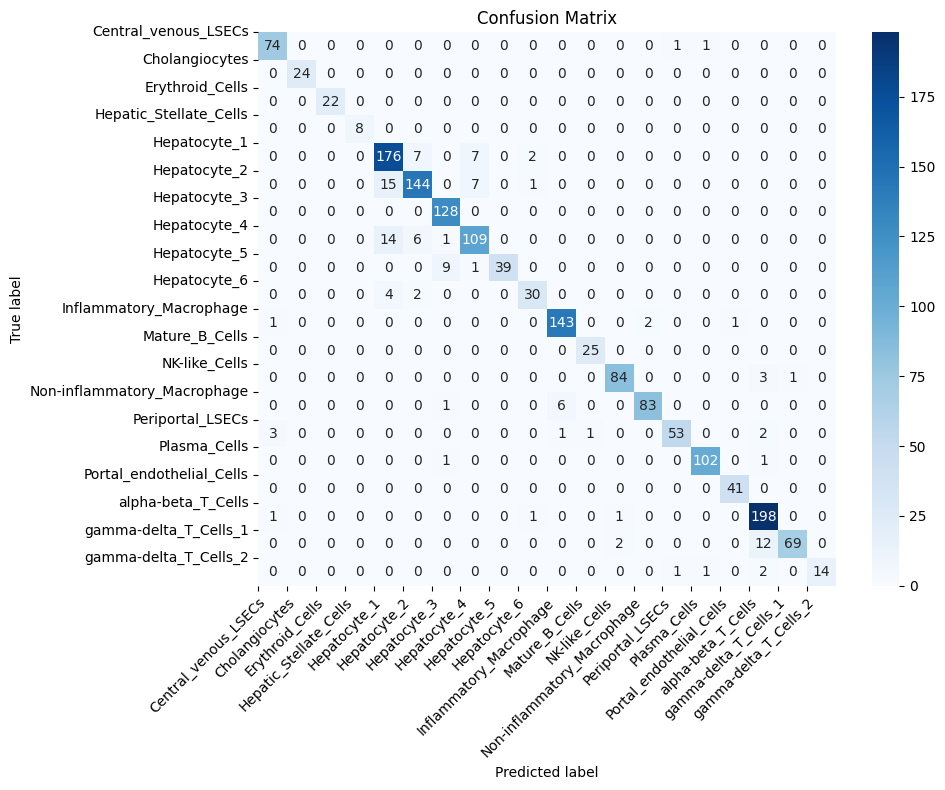

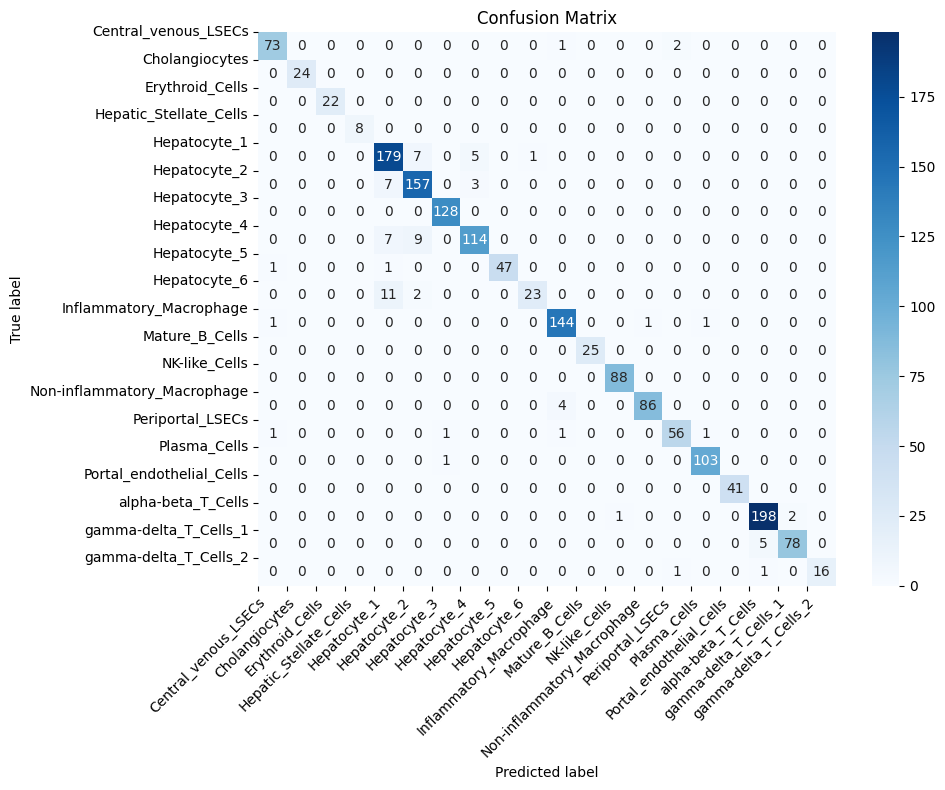

In [66]:
compute_confusion_matrix(human_model, data = hX_test, labels=hy_test, model_type = "sklearn", class_names = hle.classes_, saveas = "hum_rfc_confusion_matrix.svg")
compute_confusion_matrix(human_model_nn, data = nh_test_loader, labels = "jhjahahaoixwbncw", class_names = hle.classes_, saveas = "hum_nn_confusion_matrix.svg")

array([[  9,   0,   0,   0,   1,   0,   0,   0,   0,   2,   1,   0,   0,
          0,   0,   0,   1,   0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   1,   0,   0,   0,  13,   3,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,  11,   0,   1,   0,   0,   0,   0,   1,   0,   0,
          0,   6,   0,   0,   0],
       [  0,   0,   0,   0, 267,   5,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   4,  44,   0,   0,   0,  19,   9,   3,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   8,   2,  15,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0, 205,   0,  10,   2,   1,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   2,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,

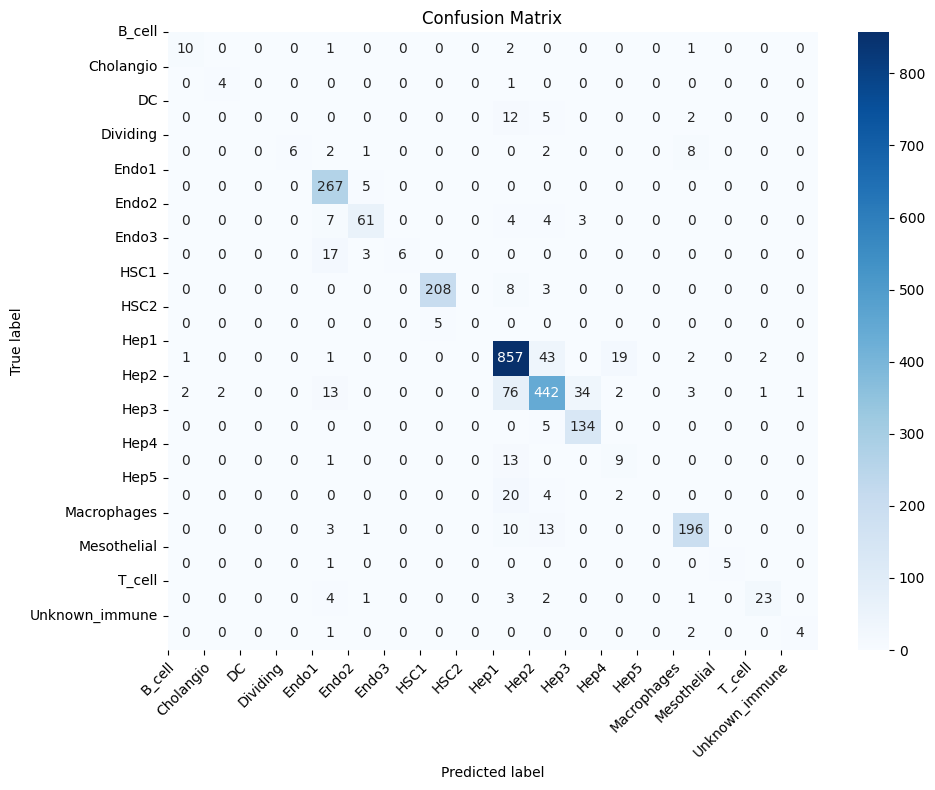

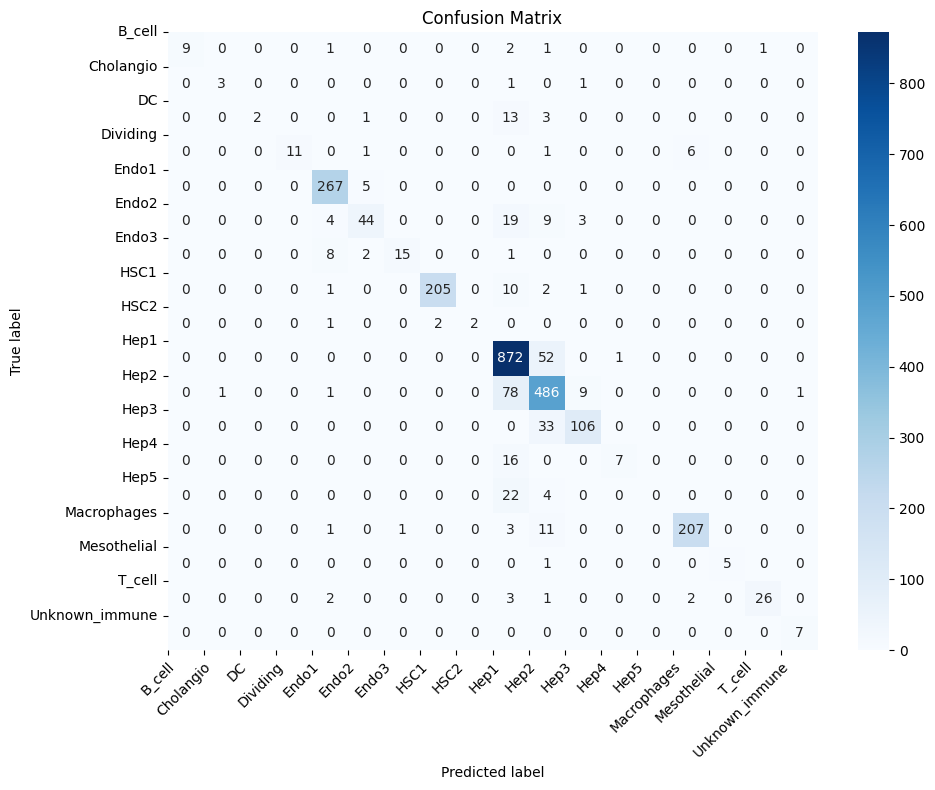

In [67]:
compute_confusion_matrix(mouse_model, data = mX_test, labels=my_test, model_type = "sklearn", class_names = mle.classes_, saveas = "mouse_rfc_confusion_matrix.svg")
compute_confusion_matrix(mouse_model_nn, data = nm_test_loader, labels = "jhjahahaoixwbncw", class_names = mle.classes_, saveas = "mouse_nn_confusion_matrix.svg")